In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
print(X.shape, y.shape)

(70000, 784) (70000,)


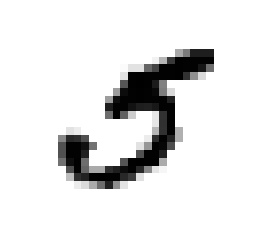

In [4]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [5]:
y[36000]

5.0

In [6]:
training_size = 60000
X_train, X_test, y_train, y_test = X[:training_size], X[training_size:], y[:training_size], y[training_size:]

import numpy as np

shuffle_index = np.random.permutation(training_size)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [8]:
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.91255
0.8734
0.93435


In [10]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[49533,  5046],
       [  548,  4873]])

In [12]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.746502612506
0.817007932116


In [13]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.78016558041218942

In [14]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[ 101367.32976161]
[ True]


In [15]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

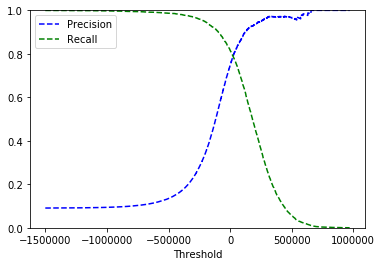

In [16]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [17]:
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

/home/ashley/ml/env/lib/python3.5/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	center right
	lower left
	lower right
	upper left
	right
	center left
	lower center
	upper right
	best
	center
	upper center

  six.iterkeys(self.codes))))


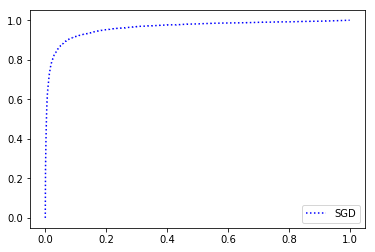

In [18]:
from sklearn.metrics import roc_curve

fpr, trp, thresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, trp, "b:", label="SGD")
#plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="bottom right")
plt.show()

In [19]:
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5
sgd_clf.predict([some_digit])

array([ 5.])

In [20]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])
len(ovo_clf.estimators_)

45

In [21]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [27]:
proba = forest_clf.predict_proba([some_digit])

In [28]:
proba.sum()

1.0

In [22]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.83453309,  0.85179259,  0.8780317 ])

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90991802,  0.91044552,  0.90818623])

Scaling the MNIST data improve the cross validation performance of the SGD model by ~3%.

In [33]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
confusion_mx = confusion_matrix(y_train, y_train_pred)
confusion_mx

array([[5717,    2,   21,   12,   11,   61,   46,    8,   40,    5],
       [   1, 6480,   45,   26,    6,   42,    7,   13,  112,   10],
       [  54,   39, 5305,  109,   85,   27,  105,   57,  159,   18],
       [  40,   43,  134, 5348,    3,  244,   37,   54,  129,   99],
       [  17,   26,   42,   10, 5355,    8,   61,   30,   80,  213],
       [  71,   48,   35,  178,   72, 4592,  113,   31,  179,  102],
       [  30,   28,   52,    2,   41,  100, 5614,    4,   46,    1],
       [  23,   20,   66,   39,   50,   14,    8, 5789,   15,  241],
       [  46,  159,   64,  167,    9,  158,   64,   34, 5009,  141],
       [  41,   28,   28,   90,  152,   34,    2,  198,   83, 5293]])

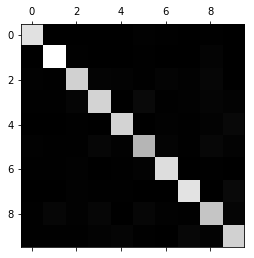

In [34]:
plt.matshow(confusion_mx, cmap=plt.cm.gray)
plt.show()

In [35]:
row_sums = confusion_mx.sum(axis=1, keepdims=True)
norm_confusion_mx = confusion_mx / row_sums

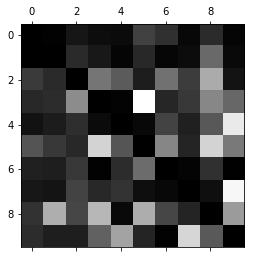

In [36]:
np.fill_diagonal(norm_confusion_mx, 0)
plt.matshow(norm_confusion_mx, cmap=plt.cm.gray)
plt.show()

In [44]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

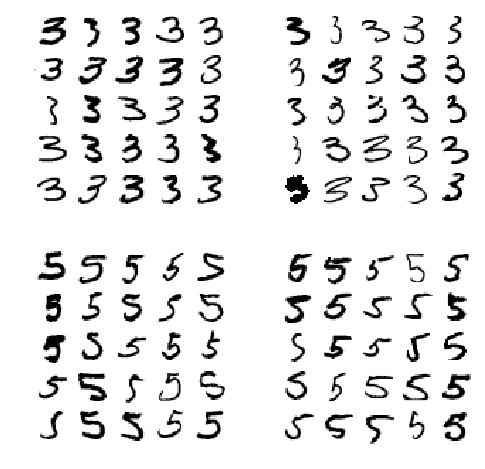

In [45]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [24]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [24]:
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal, randint

# see https://docs.scipy.org/doc/scipy-0.19.0/reference/stats.html
# for `expon()` and `reciprocal()` documentation and more probability distribution functions.

# Note: gamma is ignored when kernel is "linear"
param_distribs = {
    'n_neighbors': randint(1, 7),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree'],
}

rnd_search_one = RandomizedSearchCV(knn_clf, param_distributions=param_distribs,
                                n_iter=5, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
rnd_search_one.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] algorithm=auto, n_neighbors=3, weights=uniform ..................
[CV] algorithm=auto, n_neighbors=3, weights=uniform ..................
[CV] algorithm=auto, n_neighbors=3, weights=uniform ..................
[CV] algorithm=auto, n_neighbors=3, weights=uniform ..................
[CV] ... algorithm=auto, n_neighbors=3, weights=uniform, total=13.1min
[CV] algorithm=auto, n_neighbors=3, weights=uniform ..................
[CV] ... algorithm=auto, n_neighbors=3, weights=uniform, total=13.3min
[CV] algorithm=auto, n_neighbors=4, weights=uniform ..................
[CV] ... algorithm=auto, n_neighbors=3, weights=uniform, total=13.3min
[CV] algorithm=auto, n_neighbors=4, weights=uniform ..................
[CV] ... algorithm=auto, n_neighbors=3, weights=uniform, total=13.2min
[CV] algorithm=auto, n_neighbors=4, weights=uniform ..................
[CV] ... algorithm=auto, n_neighbors=4, weights=uniform, total=13.2min
[CV] algorithm=au

[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed: 1271.5min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
          fit_params={}, iid=True, n_iter=5, n_jobs=4,
          param_distributions={'algorithm': ['auto', 'ball_tree', 'kd_tree'], 'n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8a4f700b00>, 'weights': ['uniform', 'distance']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='neg_mean_squared_error',
          verbose=2)

In [55]:
rnd_search_one.best_estimator_

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='distance')

In [25]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
def cross_val_scores(regressor):
    scores = cross_val_score(regressor, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
    rmse_scores = np.sqrt(-scores)
    display_scores(rmse_scores)
    return rmse_scores

In [65]:
cross_val_scores(rnd_search_one.best_estimator_)

Scores: [ 0.72730395  0.68014854  0.68258505  0.73846688  0.61657657  0.70751921
  0.71198161  0.73411386  0.68403261  0.64532495]
Mean: 0.692805322699
Standard deviation: 0.0373799052971


array([ 0.72730395,  0.68014854,  0.68258505,  0.73846688,  0.61657657,
        0.70751921,  0.71198161,  0.73411386,  0.68403261,  0.64532495])

From the 5 random searches, it appears that 'kd_tree' with 1 neighbour with 'distance' weights is the best hyperparameters thus far.

Now performing a grid search relating to those parameters.

In [26]:
from sklearn.model_selection import GridSearchCV

In [66]:
param_distribs = {
    'n_neighbors': [1, 2, 3],
    'weights': ['distance'],
    'algorithm': ['kd_tree'],
}

grid_search_one = GridSearchCV(knn_clf, param_distribs, cv=5, scoring="neg_mean_squared_error")
grid_search_one.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'algorithm': ['kd_tree'], 'n_neighbors': [1, 2, 3], 'weights': ['distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [67]:
grid_search_one.best_estimator_

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')

In [43]:
param_distribs = {
    'n_neighbors': [4, 5],
    'weights': ['distance'],
    'algorithm': ['kd_tree', 'auto'],
}

grid_search_two = GridSearchCV(knn_clf, param_distribs, cv=5, scoring="neg_mean_squared_error")
grid_search_two.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'weights': ['distance'], 'n_neighbors': [4, 5], 'algorithm': ['kd_tree', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [45]:
grid_search_two.best_estimator_

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')

In [46]:
cross_val_scores(grid_search_two.best_estimator_)

Scores: [ 0.66886916  0.66866268  0.64608856  0.69016906  0.66370174  0.64010543
  0.72313241  0.61865213  0.65743145  0.6998761 ]
Mean: 0.66766887077
Standard deviation: 0.0289323939764


array([ 0.66886916,  0.66866268,  0.64608856,  0.69016906,  0.66370174,
        0.64010543,  0.72313241,  0.61865213,  0.65743145,  0.6998761 ])

In [42]:
from scipy.ndimage.interpolation import shift

def shift_image(image, direction):
        shift_sequence = None
        if direction == "left":
            shift_sequence = [0, -1]
        elif direction == "right":
            shift_sequence = [0, 1]
        elif direction == "up":
            shift_sequence = [-1, 0]
        elif direction == "down":
            shift_sequence = [1, 0]
        else:
            raise Exception("Unknown direction.")
        return shift(image, shift_sequence)

def shift_image_in_all_directions(image):
    reshaped = image.reshape(28, 28)
    return [shift_image(reshaped, direction).reshape(28 * 28) for direction in ["left", "right", "up", "down"]]

def augment_training_set(X, y):
    augmented_X, augmented_y = [], []
    for image, label in zip(X, y):
        augmented_X = augmented_X + shift_image_in_all_directions(image)
        number_of_directions = 4
        augmented_y = augmented_y + ([label] * number_of_directions)
    return np.array(augmented_X), np.array(augmented_y)

print("X size:", len(X), "y size:", len(y))
augmented_X, augmented_y = augment_training_set(X, y)
print("augmented_X size:", len(augmented_X), "augmented_y size:", len(augmented_y))
print("augmented_X shape:", augmented_X.shape, "augmented_y:", augmented_y.shape)
print(augmented_X)

X size: 70000 y size: 70000
augmented_X size: 280000 augmented_y size: 280000
augmented_X shape: (280000, 784) augmented_y: (280000,)
[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]


In [35]:
print("X shape:", X.shape, "y:", y.shape)

X shape: (70000, 784) y: (70000,)


TypeError: Invalid dimensions for image data

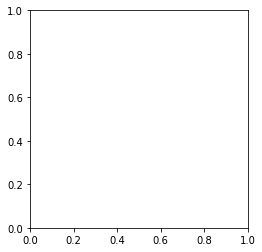

In [44]:
plt.imshow(augmented_X[0], cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

plt.imshow(augmented_X[1], cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [47]:
import os
os.system("shutdown")

0